# Challenge 2: Investigation of an anomaly regarding an API endpoint

The API endpoint "https://hk-test-api.herokuapp.com/temperature" is exhibiting unreliable behavior. An investigation and possible mitigation strategies have been requested.


In [1]:
import requests
from requests import Request, RequestException
from time import sleep
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chisquare
%matplotlib inline
sns.set_theme(style="darkgrid")

## Gathering Data on the endpoint

In [2]:
records = []
for i in range (5000):
    try:
        r = requests.get('https://hk-test-api.herokuapp.com/temperature', timeout=0.2)
        r.text
    except RequestException:
        sleep(0.10)
    sleep(0.010)
    d = dict(elapsed=r.elapsed, status=r.status_code, runtime= float(r.headers['X-Runtime']))
    records.append(d)

In [3]:
df = pd.DataFrame.from_records(records)

## Analyzing Data on the endpoint 

In [4]:
df["status"].value_counts()

500    2506
200    2494
Name: status, dtype: int64

Apparently the endpoint will throw the error Code 500 at a rate of 50%. 

In [5]:
# Compute switching frequencies
success = df["status"].values==200
frequencies = list(Counter(zip(success[1:], success[:-1])).values())
print(chisquare(frequencies))

Power_divergenceResult(statistic=0.07261452290458091, pvalue=0.994907713115282)


Failures, especially hardware failures, are often time dependent and will go on or off within certain time periods. If this were the case here, we would expect a four squares table of the switches between success and failure to deviate from equilibrium, and we could expect the null hypothesis of a chi square test to be rejected. But this is not the case, so either the switching frequency is higher than our polling frequency, or there is no temporal aspect to this problem.

Let's also investigate the response times.

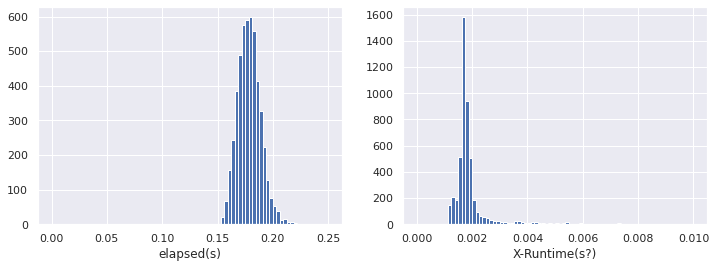

In [6]:
f,(ax1, ax2) = plt.subplots(1,2)
f.set_figwidth(12)
ax1.hist(df["elapsed"].dt.total_seconds(), bins=80, range=(0,0.25))
ax1.set_xlabel("elapsed(s)")
ax2.hist(df["runtime"],bins=80,range=(0,0.010))
ax2.set_xlabel("X-Runtime(s?)");

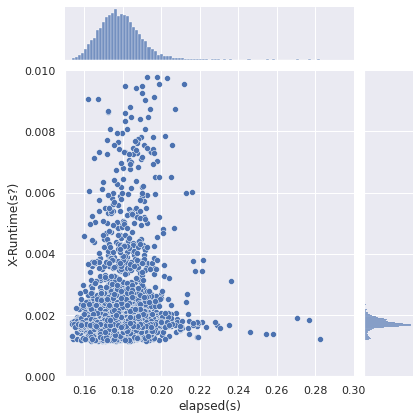

In [7]:
g = sns.jointplot(data=df, x=df["elapsed"].dt.total_seconds(), y="runtime", xlim=(0.15,0.3), ylim=(0,0.010));
g.set_axis_labels("elapsed(s)", "X-Runtime(s?)");

The "X-Runtime" header is set by the server and probably reveals how long the script or http backend handler 
behind the reverse proxy took to process the request. It is considered bad practice to reveal such information as it offers insight into the application. Sometimes such timing information can be used to access data that should be secret.

In this case, if we assume this time to be stated in seconds, we can also assume that there is no disk, database or network IO going on to fetch the temperature or to decide whether or not to throw an error code. Most likely this is just a random function returning either an error code or a constant temperature.

## Mitigation

Temperature data changes over time, but rarely requires a high or precise temporal resolution. The easiest way to handle the problem in this endpoint without changing the code in the endpoint would be to keep the value from the last successful retrieval until the next successful request, as indicated by the request code. This can either be achieved in the client code or even in the reverse proxy configuration.

### Client Side Example (Python)

In [8]:
temp = None
for i in range(10):
    r = requests.get('https://hk-test-api.herokuapp.com/temperature', timeout=0.2)
    if r.status_code == 200:
        temp = r.text
    if temp is not None:
        print (temp)
        

13.5
13.5
13.5
13.5
